# Exploratory Data Analysis

In [1]:
import pandas as pd
import re, string, unicodedata
import nltk
import contractions
import inflect
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer
from nltk.tokenize import TweetTokenizer
import collections
import pickle

train_path = '../data/train.csv'
test_path = '../data/test.csv'

In [2]:
# Load data
train = pd.read_csv(train_path, header=None, encoding='iso-8859-1')
test = pd.read_csv(test_path, header=None, encoding='iso-8859-1')

The original data came split into train and test datasets. For EDA, these datasets were combined into one.

In [3]:
# Concatenate train and test datasets and remove unnecessary columns
data = pd.concat([train, test])
data = data.drop([1, 2, 3, 4], axis=1)
data.columns = ['sentiment', 'text']
data.head()

,sentiment,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


From the distribution of labels in the data, we can see that we have very few examples of neutral tweets. These tweets were removed from the dataset. The final model for the project will predict just two values, negative and positive.

<AxesSubplot:title={'center':'Tweet Count by Sentiment'}, xlabel='sentiment'>

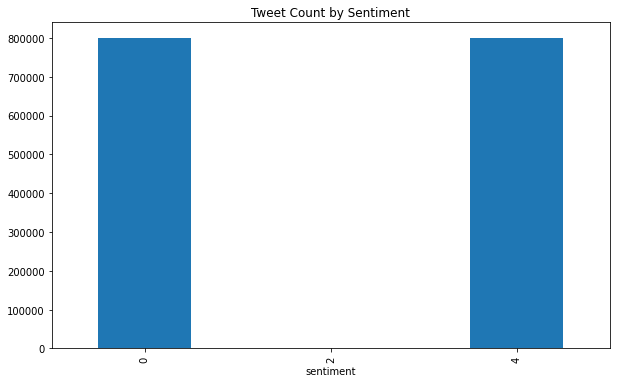

In [4]:
# Plot histogram of labels
data.groupby('sentiment').count().plot(kind='bar', title='Tweet Count by Sentiment', figsize=(10, 6), legend=False)

In [5]:
# Drop neutral tweets from dataset
data.drop(data[data.sentiment == 2].index, inplace=True)
data.groupby('sentiment').count()

,text
sentiment,
0,800038
4,800182


Since tweets can only be 140 characters long, any tweet in the dataset with more than 140 characters is considered to be an outlier. The code below removes these outliers.

In [6]:
# Create field with tweet length
data['len'] = data.text.str.len()

<AxesSubplot:title={'center':'Tweet Length Histogram'}, ylabel='Frequency'>

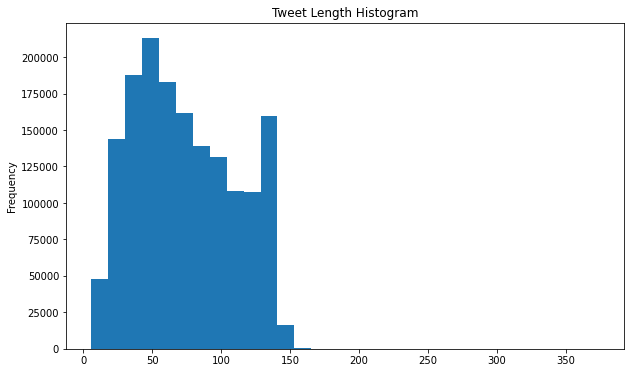

In [7]:
# Plot histogram of tweet length 
data['len'].plot.hist(bins=30, title='Tweet Length Histogram', figsize=(10, 6))

In [8]:
# Drop tweets longer than 140 characters
data.drop(data[data.len > 140].index, inplace=True)
data.groupby('sentiment').count()

,text,len
sentiment,,
0,792160,792160
4,790875,790875


## Text Preprocessing

The functions below are used for preprocessing the tweet text. These will be applied to the dataset prior to model training.

In [9]:
# Replace contractions
def replace_contraction(text):
    text = contractions.fix(text)
    
    return text

# Remove URLs
def remove_url(text):
    text = re.sub(r'http\S+', '', text)

    return text

# Tokenize tweets
def tokenize_tweet(text):
    tknzr = TweetTokenizer(preserve_case=False, strip_handles=True)
    text= tknzr.tokenize(text)
    
    return text

# Remove non-ASCII character
def remove_non_ascii(words):
    new_words = []
    for w in words:
        new_word = unicodedata.normalize('NFKD', w).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    
    return new_words

# Remove punctuation
def remove_punctuation(words):
    new_words = []
    for w in words:
        new_word = re.sub(r'[^\w\s]', '', w)
        if new_word != '':
            new_words.append(new_word)
    
    return new_words

# Replace numbers
def replace_number(words):
    p = inflect.engine()
    new_words = []
    for w in words:
        if w.isdigit():
            new_word = p.number_to_words(w)
            new_words.append(new_word)
        else:
            new_words.append(w)
    return new_words

# Remove stopwords
def remove_stopwords(words):
    new_words = []
    for w in words:
        if w not in stopwords.words('english'):
            new_words.append(w)
    return new_words

# Stem words
def stem_words(words):
    stemmer = LancasterStemmer()
    stems = []
    for w in words:
        stem = stemmer.stem(w)
        stems.append(stem)
    
    return stems

# Lemmatize verbs
def lemmatize_verbs(words):
    lemmatizer = WordNetLemmatizer()
    lemmas = []
    for w in words:
        lemma = lemmatizer.lemmatize(w, pos='v')
        lemmas.append(lemma)
    
    return lemmas

# Combine normalizing functions
def normalize(words):
    words = remove_non_ascii(words)
    words = remove_punctuation(words)
    words = replace_number(words)
    words = remove_stopwords(words)
    words = stem_words(words)
    words = lemmatize_verbs(words)
    
    return words

# Create function for text preprocessing
def preprocess(text):
    text = remove_url(text)
    text = replace_contraction(text)
    words = tokenize_tweet(text)
    words = normalize(words)
    
    return words

In [10]:
# Apply text preprocessing functions
doc = []
for i in data.text.values:
    doc.append(preprocess(i))

The script below shows top 30 most used words (excluding stopwords that are already removed from the tweets).

In [11]:
# Flatten tokens
vocab = [word for tweet in doc for word in tweet]

# Grap top 30 most used words from dataset
vocab_count = collections.Counter(vocab)
vocab_count = pd.DataFrame.from_dict(dict(vocab_count), orient='index').reset_index()
vocab_count.columns = ['word', 'count']
vocab_count = vocab_count.sort_values(by='count', ascending=False)
vocab_count.head(30)

,word,count
3,get,179800
29,go,173279
7,day,102591
163,good,91019
141,work,86671
96,lov,84580
35,lik,81917
94,want,72871
105,on,68832
18,today,67561


In [12]:
# Save tokens
labels = data.sentiment.tolist()
tokens = []

for i in range(len(doc)):
    tokens.append([labels[i], doc[i]])
    
open_file = open('../data/preprocessed/tokens.pkl', "wb")
pickle.dump(tokens, open_file)
open_file.close()